In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML                                     #Importing required Libraries

#### Installing previous version of tensorflow as latest version not supporting epoch

In [33]:
!pip install tensorflow==2.7.0                                     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 665.5 MB 22 kB/s 
     |████████████████████████████████| 463 kB 33.2 MB/s 
     |████████████████████████████████| 1.3 MB 53.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50                                                 # Define Constants

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data_science/flowers",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)                                                         #importing dataset and dividing into batches

Found 1694 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names                                       # to determine classes in our dataset

['daisy', 'rose', 'sunflower', 'tulip']

In [37]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch)                       # finding Shape of image batch

(32, 256, 256, 3)
tf.Tensor([0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 2 0 1 0 2 1 2 1 1 1 0 1 1 2 1 1 0], shape=(32,), dtype=int32)


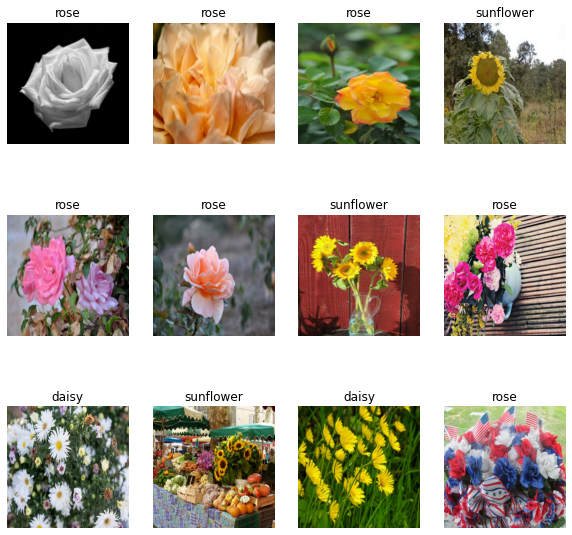

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")                           # plotting images in a batch

### defined a function to split dataset into training , validation and testing

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

#### Shuffling images in each dataset and buffer size will be defined by autotune for prefetching the elements while runtime

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Resizing the images to same size so as the input to CNN will be of uniform size, as to process the data CNN needs input of same size

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### data augmenting to provide vertical, horizontal and rotated images input to the neural network

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### applying data augmentation and Autotune to train dataset

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

#### defining input shape and building sequential model using relu and Softmax activication funtion.

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

#### Compling model using adam as optimizer and CrossEntropy as loss function

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### training the model in batches, finding training and validation accuracy in 20 epochs iterations

In [17]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
42/42 [==============================] - 33s 423ms/step - loss: 1.0307 - accuracy: 0.4262 - val_loss: 0.9025 - val_accuracy: 0.4875
Epoch 2/20
42/42 [==============================] - 11s 271ms/step - loss: 0.8319 - accuracy: 0.5939 - val_loss: 0.6493 - val_accuracy: 0.7563
Epoch 3/20
42/42 [==============================] - 11s 268ms/step - loss: 0.5952 - accuracy: 0.7608 - val_loss: 0.5150 - val_accuracy: 0.7875
Epoch 4/20
42/42 [==============================] - 11s 267ms/step - loss: 0.5663 - accuracy: 0.7779 - val_loss: 0.4626 - val_accuracy: 0.8250
Epoch 5/20
42/42 [==============================] - 11s 269ms/step - loss: 0.5622 - accuracy: 0.7802 - val_loss: 0.4020 - val_accuracy: 0.8562
Epoch 6/20
42/42 [==============================] - 11s 268ms/step - loss: 0.5202 - accuracy: 0.7914 - val_loss: 0.4283 - val_accuracy: 0.8188
Epoch 7/20
42/42 [==============================] - 11s 267ms/step - loss: 0.5096 - accuracy: 0.7951 - val_loss: 0.4286 - val_accuracy: 0.8438

In [18]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 7s 25ms/step - loss: 0.4205 - accuracy: 0.8333


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#### plotting graph comparing training and Validation acurracy , Losses.

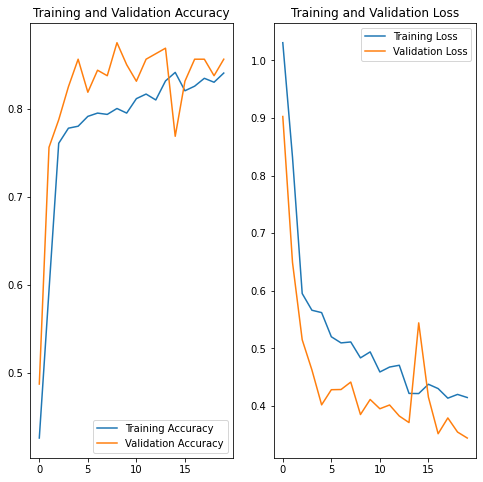

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### trying to predict 1st image in the batch

first image to predict
actual label: sunflower
predicted label: daisy


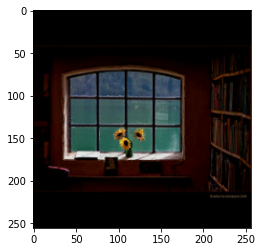

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### define a function to return predicted class of image and confidence of prediction of model

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

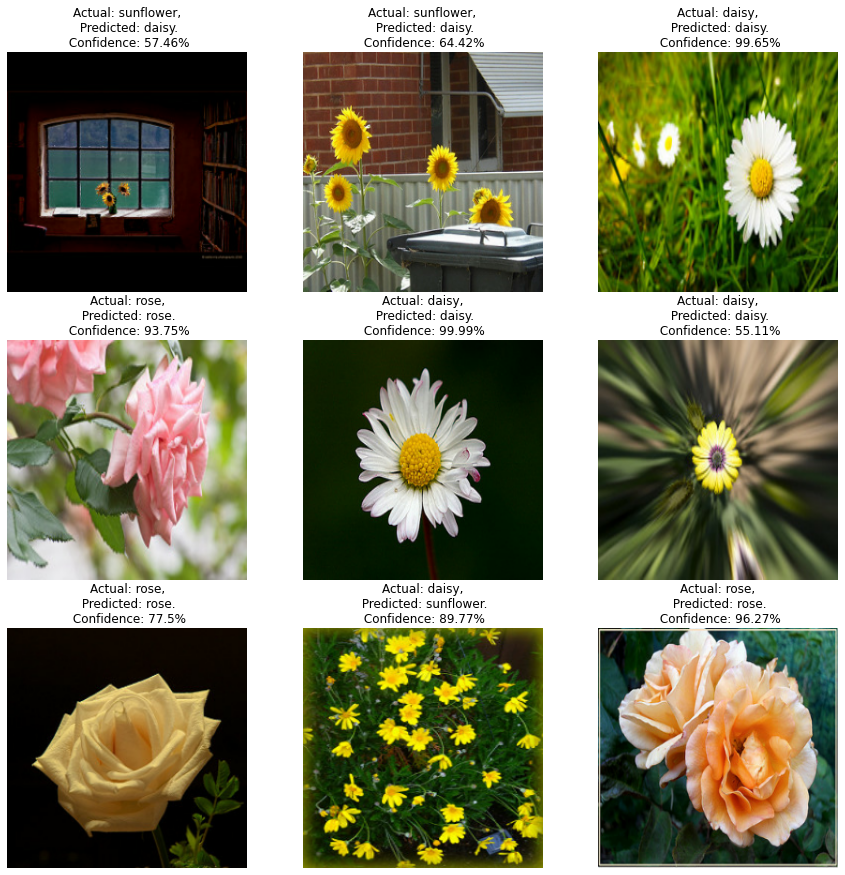

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## -------------------------------------------------------------------

#### Now, Using transfer learning technique for image classification using VGG19() function model for prediction

In [25]:
model=tf.keras.applications.VGG19()
model.summary()

574726144/574710816 [==============================] - 22s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

#### passing input shape to VGG19() by keepping include_top = false to avoid including fully connected layer at the top of network.

In [32]:
vgg19=tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(256,256,3)
)
vgg19.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [28]:
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D

#### building sequential model by adding VGG19() transfer learning model into it.

In [33]:
model=tf.keras.models.Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               16777728  
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,868,292
Trainable params: 36,868,292
Non-trainable params: 0
_________________________________________________________________


#### Compling model using adam as optimizer and CrossEntropy as loss function

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### training the model in batches, finding training and validation accuracy in 20 epochs iterations

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=20,
)

Epoch 1/20
42/42 - 25s - loss: 0.9647 - accuracy: 0.4374 - val_loss: 0.9190 - val_accuracy: 0.4812 - 25s/epoch - 607ms/step
Epoch 2/20
42/42 - 25s - loss: 0.9072 - accuracy: 0.5022 - val_loss: 0.7745 - val_accuracy: 0.6625 - 25s/epoch - 606ms/step
Epoch 3/20
42/42 - 25s - loss: 0.8563 - accuracy: 0.5790 - val_loss: 0.7000 - val_accuracy: 0.7000 - 25s/epoch - 600ms/step
Epoch 4/20
42/42 - 26s - loss: 0.7567 - accuracy: 0.6580 - val_loss: 0.6726 - val_accuracy: 0.6812 - 26s/epoch - 609ms/step
Epoch 5/20
42/42 - 26s - loss: 0.7135 - accuracy: 0.6826 - val_loss: 0.6803 - val_accuracy: 0.7437 - 26s/epoch - 608ms/step
Epoch 6/20
42/42 - 27s - loss: 0.6758 - accuracy: 0.7198 - val_loss: 0.5509 - val_accuracy: 0.7500 - 27s/epoch - 637ms/step
Epoch 7/20
42/42 - 26s - loss: 0.7205 - accuracy: 0.7086 - val_loss: 0.5540 - val_accuracy: 0.8125 - 26s/epoch - 624ms/step
Epoch 8/20
42/42 - 26s - loss: 0.6355 - accuracy: 0.7519 - val_loss: 0.6498 - val_accuracy: 0.7063 - 26s/epoch - 608ms/step
Epoch 9/

## ------------------------------------------------------------------------

#### Now, Using transfer learning technique for image classification using InceptionV3() function model for prediction

In [38]:
model=tf.keras.applications.InceptionV3()
model.summary()

96124928/96112376 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 149, 149, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_6[0][0]']               
 alization)           

In [39]:
InceptionV3=tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(256,256,3)
)
InceptionV3.summary()

87924736/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 127, 127, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_100[0][0]']             
 ormalization)        

In [40]:
model=tf.keras.models.Sequential()
model.add(InceptionV3)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(4,activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 73728)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               37749248  
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                                 
 dense_10 (Dense)            (None, 4)                 516       
                                                                 
Total params: 59,618,212
Trainable params: 59,583,780
Non-trainable params: 34,432
_________________________________________________________________


In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [42]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=20,
)

Epoch 1/20
42/42 - 28s - loss: 4.3307 - accuracy: 0.5507 - val_loss: 658.1971 - val_accuracy: 0.4875 - 28s/epoch - 677ms/step
Epoch 2/20
42/42 - 14s - loss: 0.4993 - accuracy: 0.7936 - val_loss: 151.0757 - val_accuracy: 0.4875 - 14s/epoch - 343ms/step
Epoch 3/20
42/42 - 15s - loss: 0.4672 - accuracy: 0.8607 - val_loss: 19.4954 - val_accuracy: 0.4875 - 15s/epoch - 349ms/step
Epoch 4/20
42/42 - 15s - loss: 0.3150 - accuracy: 0.8875 - val_loss: 1.3563 - val_accuracy: 0.5250 - 15s/epoch - 354ms/step
Epoch 5/20
42/42 - 15s - loss: 0.2470 - accuracy: 0.9218 - val_loss: 13.6501 - val_accuracy: 0.5188 - 15s/epoch - 365ms/step
Epoch 6/20
42/42 - 14s - loss: 0.3184 - accuracy: 0.8800 - val_loss: 86.3691 - val_accuracy: 0.5000 - 14s/epoch - 339ms/step
Epoch 7/20
42/42 - 14s - loss: 0.2444 - accuracy: 0.9061 - val_loss: 6.9121 - val_accuracy: 0.7500 - 14s/epoch - 340ms/step
Epoch 8/20
42/42 - 14s - loss: 0.1796 - accuracy: 0.9322 - val_loss: 0.7404 - val_accuracy: 0.9000 - 14s/epoch - 342ms/step
E

In [43]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 1s 115ms/step - loss: 0.3853 - accuracy: 0.9010


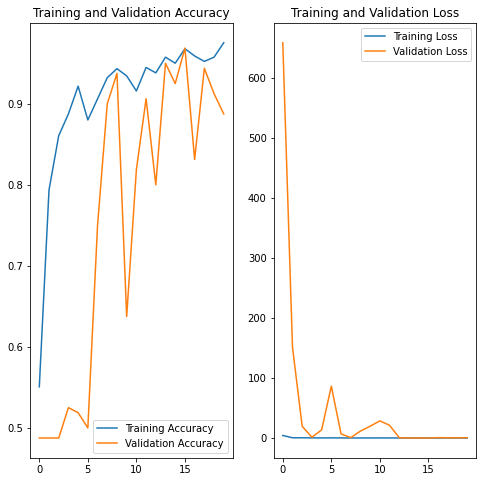

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc, label='Training Accuracy')
plt.plot(range(20), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss, label='Training Loss')
plt.plot(range(20), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

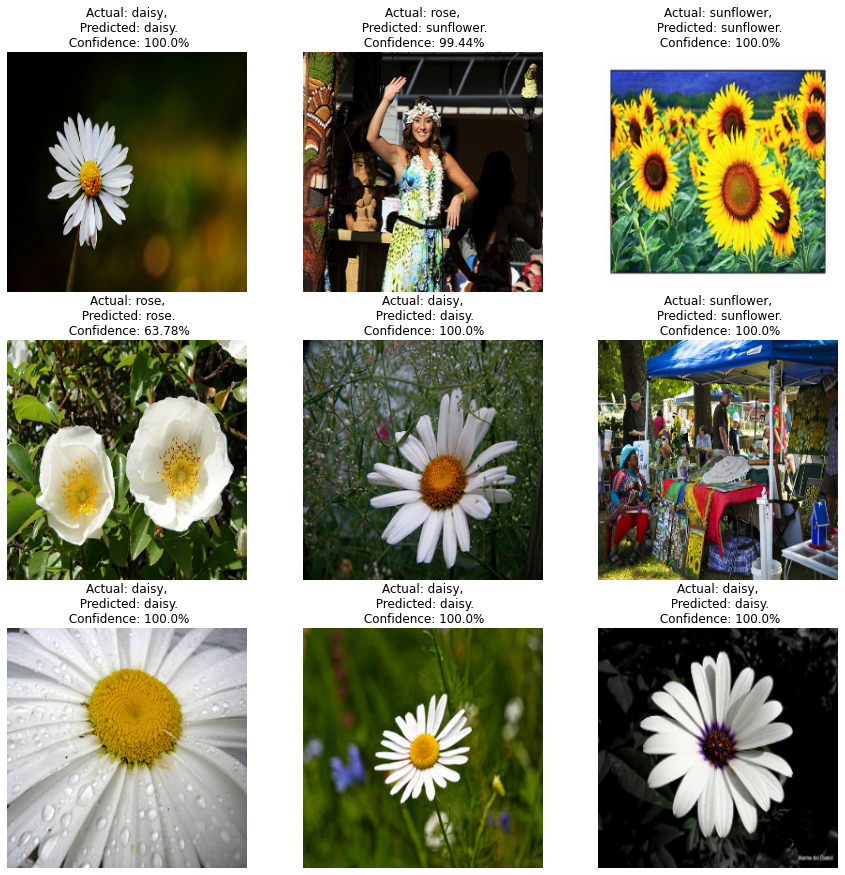

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")